<a href="https://colab.research.google.com/github/Ying-Yuan07/TensorFlowLearn/blob/main/app%E4%BD%BF%E7%94%A8%E6%8E%A8%E8%8D%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

values.shape
(295310, 4)
[[  0  19   0   1]
 [  0   0   0   1]
 [  0   8   0   1]
 ...
 [291   4   0   3]
 [291   4   0   3]
 [291  17   0   3]]
        var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var1(t)  var2(t)  var3(t)  var4(t)
0             NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN      0.0     0.95      0.0      0.2
1             NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        0.0       0.95        0.0        0.2      0.0     0.00      0.0      0.2
2             NaN        NaN        NaN        NaN        0.0       0.95        0.0        0.2        0.0       0.00        0.0        0.2      0.0     0.40      0.0      0.2
3             0.0       0.95        0.0        0.2        0.0       0.00        0.0        0.2        0.0       0.40        0.0        0.2      0.0     0.0

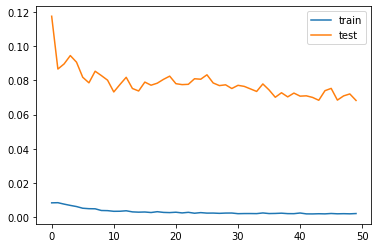

Test RMSE: 22.565


In [10]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd

"""
本文是LSTM多元预测：app
用3个步长的数据预测1个步长的数据
包含：
对数据进行缩放，缩放格式为n行*4列
构造3->1的监督学习数据
构造网络开始预测
将预测结果重新拼接为n行*8列数据
数据逆缩放，求RSME误差
"""
pd.set_option('display.max_columns',1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',1000)

# 转换成监督数据，四列数据，3->1，三组预测一组
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将3组输入数据依次向下移动3，2，1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
    	cols.append(df.shift(-i))
    	if i == 0:
    		names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    	else:
    		names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有四块经过下移后的数据(即：df(-3),df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    print(agg)
    # 删除NaN值列
    if dropnan:
    	agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('./sample_data/username.csv', header=0)
values = dataset.values
print("values.shape")
print(values.shape)
print(values)
values = values.astype('float32')
# 标准化/放缩 特征值在（0,1）之间
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# 用3小时数据预测一小时数据，4个特征值
n_hours = 3
n_features = 4
# 构造一个3->1的监督学习型数据
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
# 用一年的数据来训练
n_train_hours = int(values.shape[0]* 0.7)
print(values.shape[0])
print(n_train_hours)



train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
# 有16=(4*4)列数据，取前12=(3*4) 列作为X，倒数第4列=(第13列)作为Y
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# 将数据转换为3D输入，timesteps=3，3条数据预测1条 [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# 设计网络
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# 拟合网络
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# 执行预测
yhat = model.predict(test_X)
# 将数据格式化成 n行 * 24列
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# 将预测列据和后3列数据拼接，因后续逆缩放时，数据形状要符合 n行*8列 的要求
inv_yhat = concatenate((yhat, test_X[:, -3:]), axis=1)
# 对拼接好的数据进行逆缩放
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
# 将真实列据和后3列数据拼接，因后续逆缩放时，数据形状要符合 n行*8列 的要求
inv_y = concatenate((test_y, test_X[:, -3:]), axis=1)
# 对拼接好的数据进行逆缩放
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# 计算RMSE误差值
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)